In [2]:
import csv
import datetime
import math
import matplotlib.pyplot as plt

from collections import defaultdict

KEY_COUNTRY = 1
KEY_DATES_START = 4

# Returns a proper `datetime` from `date_str` in a format like
# '1/22/20', which represents January 22nd, 2020.
def make_date(date_str):
    parts = date_str.split('/')
    assert(len(parts) == 3)
    return datetime.date(2000 + int(parts[2]), int(parts[0]), int(parts[1]))

class DayData(object):
    def __init__(self, confirmed, recovered, dead):
        self.confirmed = confirmed
        self.recovered = recovered
        self.dead = dead

    def __repr__(self):
        return 'c: {}, r: {}, d: {}'.format(self.confirmed, self.recovered, self.dead)

class Country(object):
    def __init__(self, name, population, kind_data):
        self.name = name
        self.population = population
        self.timeseries = [DayData(confirmed, recovered, dead)
            for confirmed, recovered, dead in
                zip(kind_data['confirmed'], kind_data['recovered'], kind_data['dead'])]

    def __repr__(self):
        return '{}: [{}]'.format(self.name, ', '.join(str(dd) for dd in self.timeseries))

    def _project(self, perm, dayfn):
        factor = 1000.0/self.population if perm else 1.0
        return [dayfn(day) * factor for day in self.timeseries]

    def confirmed(self, perm=False):
        return self._project(perm, lambda day: day.confirmed)

    def recovered(self, perm=False):
        return self._project(perm, lambda day: day.recovered)

    def dead(self, perm=False):
        return self._project(perm, lambda day: day.dead)

    def dispatch(self, series, perm=False):
        if series == 'confirmed':
            return self.confirmed(perm)
        elif series == 'recovered':
            return self.recovered(perm)
        elif series == 'dead':
            return self.dead(perm)
        else:
            raise Exception('unknown series in dispatch: ' + series)

def read_one_data_series(series):
    country_data = dict()
    with open('data/{}.csv'.format(series)) as fin:
        reader = csv.reader(fin, delimiter=',', quotechar='"')
        header = next(reader)
        dates = [make_date(date_str) for date_str in header[KEY_DATES_START:]]
        for line in reader:
            name = line[KEY_COUNTRY]
            vals = [int(v) for v in line[KEY_DATES_START:]]
            assert(len(vals) == len(dates))
            if name not in country_data:
                country_data[name] = vals
            else:
                # Another province/state for the same country.
                # We just sum this up.
                cur = country_data[name]
                assert(len(cur) == len(vals))
                for i in range(len(cur)):
                    cur[i] += vals[i]
    return dates, country_data

class DB(object):
    def __init__(self):
        self.dates = None
        # {country -> kind -> numbers}
        per_country = defaultdict(dict)
        for series in ['confirmed', 'recovered', 'dead']:
            dates, country_data = read_one_data_series(series)
            if self.dates is None:
                self.dates = dates
            else:
                # We're assuming all the dates are present in all the datasets.
                assert(self.dates == dates)
            if len(per_country) > 0:
                assert(set(per_country.keys()) == set(country_data.keys()))
            for country, vals in country_data.items():
                per_country[country][series] = vals

        # {country name -> population}
        populations = dict()
        with open('data/country_population.txt') as fin:
            for line in fin:
                parts = line.split(' ')
                populations[' '.join(parts[:-1])] = int(parts[-1])
        self.countries = dict()
        for name, kind_data in per_country.items():
            try:
                pop = populations[name]
            except:
                pop = 0
            self.countries[name] = Country(name, pop, kind_data)

    def country(self, country_name):
        return self.countries[country_name]

In [3]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

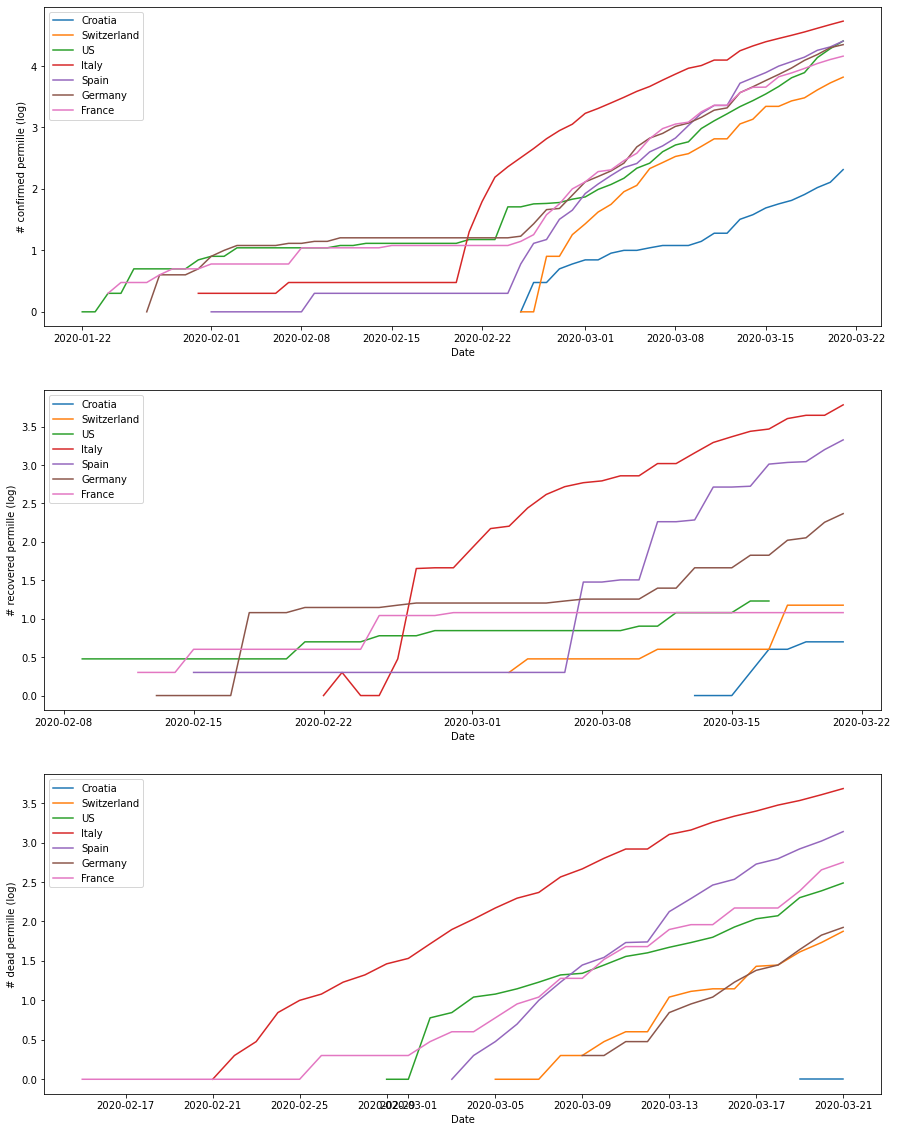

In [4]:
def log(lst):
    return [None if x == 0 else math.log10(x) for x in lst]

db = DB()

to_plot = ['Croatia', 'Switzerland', 'US', 'Italy', 'Spain', 'Germany', 'France']
fig, axes = plt.subplots(3, 1, figsize=(15, 20))

for i, series in enumerate(['confirmed', 'recovered', 'dead']):
    ax = axes[i];
    for cname in to_plot:
        ax.plot(db.dates, log(db.country(cname).dispatch(series)), label=cname)
    ax.set_ylabel('# {} permille (log)'.format(series))
    ax.set_xlabel('Date')
    ax.legend()

plt.show()

Start date 2020-02-29
Best fit: 0.8394406082169348 * exp10(0.10663343725293851 * t)


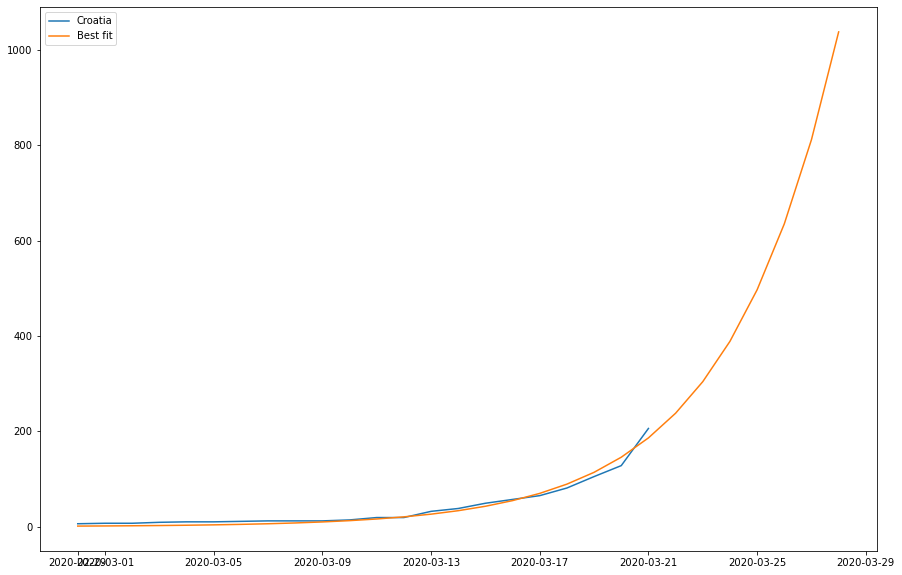

In [5]:
import numpy as np

from scipy.optimize import curve_fit
from scipy.special import exp10

def get_start_and_align(country_name, series, start_val, perm):
    data = db.country(country_name).dispatch(series, perm=perm)
    for i, (t, val) in enumerate(zip(db.dates, data)):
        if val > start_val:
            return db.dates[i:], data[i:]

dates, cro_confirmed = get_start_and_align('Croatia', 'confirmed', 5, perm=False)
print('Start date', dates[0])
(a, b), _ = curve_fit(lambda t, a, b: a * exp10(b*t), np.arange(1, len(cro_confirmed) + 1), cro_confirmed, p0=(1, 0.3))
print('Best fit: {} * exp10({} * t)'.format(a, b))

DAYS_EXTEND = 7

ts_extended = np.arange(1, len(cro_confirmed) + 1 + DAYS_EXTEND)
dates_extended = dates[::] + [dates[-1] + datetime.timedelta(days=d) for d in range(1, DAYS_EXTEND + 1)]
fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(dates, cro_confirmed, label='Croatia')
ax.plot(dates_extended, a * exp10(b * ts_extended), label='Best fit')
ax.legend()
plt.show()

Best fit Croatia: 7.746461114812233e-05 * exp10(0.10643047551380218 * t)
Best fit Italy: 0.009917825583652742 * exp10(0.06553110534614386 * t)
Best fit Switzerland: 0.0021672506023745625 * exp10(0.09780236494752122 * t)


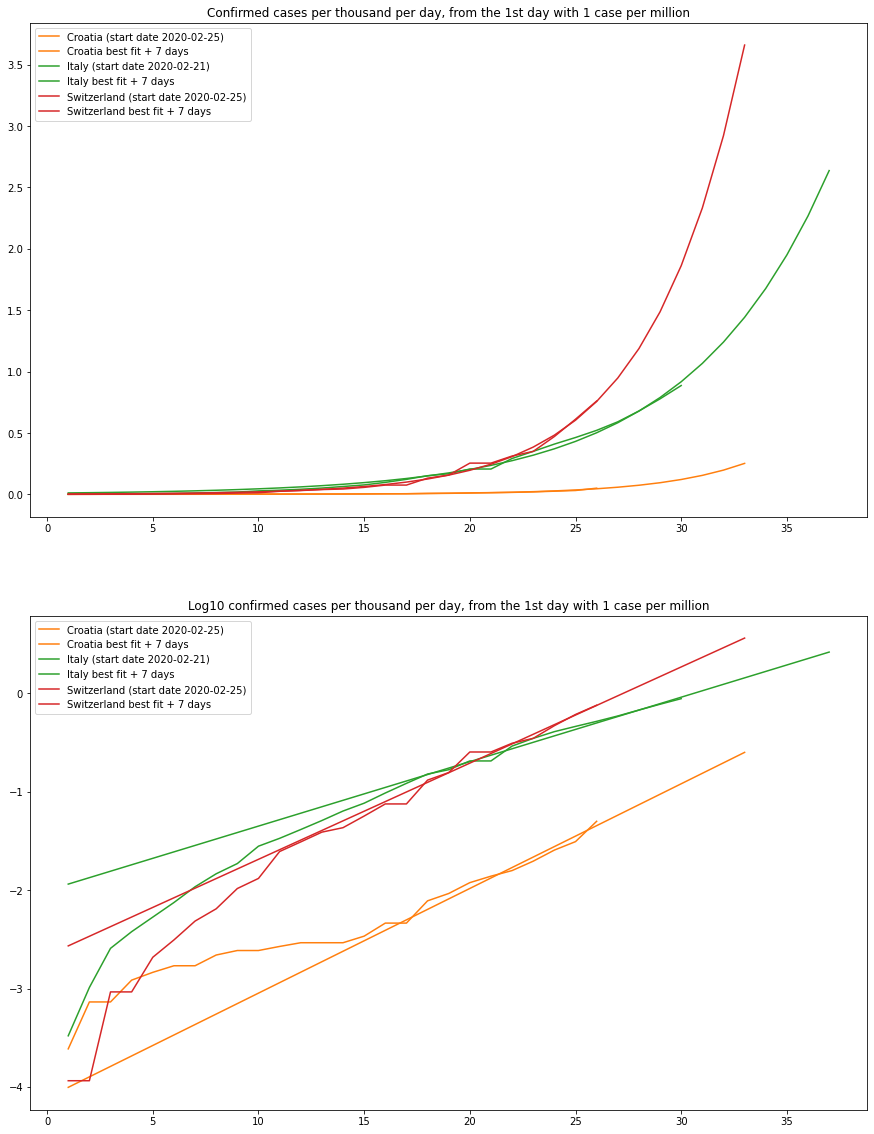

In [13]:
to_plot = ['Croatia', 'Italy', 'Switzerland']

DAYS_EXTEND = 7

def identity(lst):
    return lst

fig, axes = plt.subplots(2, 1, figsize=(15, 20))

for cidx, country in enumerate(to_plot):
    # Start each country when they had 1 case per million.
    dates, confirmed = get_start_and_align(country, 'confirmed', 0.0001, perm=True)
    data_label = '{} (start date {})'.format(country, dates[0])
    fit_label = '{} best fit + {} days'.format(country, DAYS_EXTEND)
    xs = np.arange(1, len(confirmed) + 1)
    (a, b), _ = curve_fit(lambda t, a, b: a * exp10(b*t), xs, confirmed, p0=(1, 0.3))
    print('Best fit {}: {} * exp10({} * t)'.format(country, a, b))
    
    xs_extended = np.arange(1, len(xs) + 1 + DAYS_EXTEND)
    color = 'C{}'.format(cidx + 1)
    
    for fnidx, fn in enumerate([identity, log]):
        ax = axes[fnidx]
        ax.plot(xs, fn(confirmed), color, label=data_label)
        ax.plot(xs_extended, fn(a * exp10(b * xs_extended)), color, label=fit_label)

axes[0].legend()
axes[0].set_title('Confirmed cases per thousand per day, from the 1st day with 1 case per million')
axes[1].legend()
axes[1].set_title('Log10 confirmed cases per thousand per day, from the 1st day with 1 case per million')
plt.show()